# Test: Multiple Counties
* Find where providers don't have service in several counties before applying functions to the entire state.

In [11]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
import utilities
from calitp import *
from shared_utils import geography_utils

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

In [12]:
ca_counties = utilities.get_counties()

In [13]:
# Replace spaces with _ 
ca_counties['county_name'] = ca_counties['county_name'].str.replace(' ','_')

In [14]:
# Read in ATT
att = dg.read_parquet("ATT.parquet")

## Go through several counties

In [15]:
# Grab all counties in SF 
ca_counties_list = ca_counties.county_name.unique().tolist()

In [16]:
# Subset to test
ca_counties_list = ca_counties_list[30:40]

In [17]:
# Filter ca_counties gdf for each county 
for i in ca_counties_list:
    exec(f"{i}_gdf = ca_counties[ca_counties['county_name']== i].reset_index(drop=True)")

In [18]:
# Create a list to hold each dataframe 
string = '_gdf'
counties_gdf_list = [x + string for x in ca_counties_list]

In [22]:
# Apply function to each gdf
for county in counties_gdf_list:
    exec(f"{county} = (utilities.find_difference_and_clip(att, {county}))")

In [27]:
# att_test = [x for x in counties_gdf_list]

In [28]:
# Compare LA with debug_ah.ipynb results
# Blue are areas that are in LA County but aren't covered by AT&T
# This is accurate
# Los_Angeles_gdf.plot()

In [30]:
# Remove quotes from list, since these aren't strings. They are dataframes. 
counties_gdf_list = [Placer_gdf,
 Plumas_gdf,
 Riverside_gdf,
 Sacramento_gdf,
 San_Benito_gdf,
 San_Bernardino_gdf,
 San_Diego_gdf,
 San_Francisco_gdf,
 San_Joaquin_gdf,
 San_Luis_Obispo_gdf]

In [31]:
# Concat using dask 
# https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/gtfs_utils.py#L563-L564
att_concat = dd.multi.concat(counties_gdf_list, axis=0)

In [36]:
type(att_concat)

dask_geopandas.core.GeoDataFrame

In [39]:
att_concat_gpd = att_concat.compute()

In [40]:
type(att_concat_gpd)

geopandas.geodataframe.GeoDataFrame

In [44]:
att_concat_gpd = att_concat_gpd.dissolve().drop(columns = ['county_name'])

<AxesSubplot:>

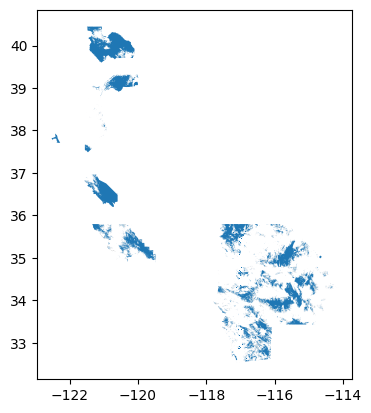

In [45]:
att_concat_gpd.plot()

In [41]:
# Dask geopandas - having trouble dissolving using dask 
# https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.dissolve.html
# att_concat.dg.dissolve(att_concat, "geometry")

In [46]:
routes_df = utilities.load_unique_routes_df()

In [48]:
type(routes_df)

geopandas.geodataframe.GeoDataFrame

In [47]:
o1 = gpd.overlay(routes_df, att_concat_gpd, how="intersection")

GEOSException: TopologyException: side location conflict at -116.952821 33.146236999999999. This can occur if the input geometry is invalid.

### Testing with subset

In [ ]:
counties_wanted = ['San_Francisco','Los_Angeles','San_Mateo', 'Mariposa']
# Subset to a few counties
ca_subset = ca_counties[ca_counties["county_name"].isin(counties_wanted)]

In [ ]:
att_placer = find_difference_and_clip(att, Placer_df)

In [ ]:
att_placer.plot()

In [ ]:
att_sma = find_difference_and_clip(att, San_Mateo_df)

In [ ]:
att_sf = find_difference_and_clip(att, San_Francisco_df)

In [ ]:
att_mariposa = find_difference_and_clip(att, Mariposa_df)

In [ ]:
att_la.plot()

In [ ]:
test = dd.multi.concat([att_sma, att_placer, att_sf,att_mariposa], axis=0)

In [ ]:
test = test.compute()

In [ ]:
type(test)

In [ ]:
test_dissolved = test.dissolve().drop(columns = 'county_name')

In [ ]:
test_dissolved.plot()

In [ ]:
agency_wanted = [
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Golden Gate Bridge Highway and Transportation District",
    "SamTrans",
    "MUNI",
    "Yosemite Area Regional Transportation System",
    "Roseville Transit"
]

routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "None"
]


def subset_routes(agency_wanted, routes_wanted):
    # Filter out
    routes_subset = routes_df[
        routes_df["route_name"].isin(routes_wanted)
        & routes_df["agency"].isin(agency_wanted)
    ]
    return routes_subset


routes_subset = subset_routes(agency_wanted, routes_wanted)

In [ ]:
routes_subset

In [ ]:
o1 = gpd.overlay(routes_subset, test_dissolved, how="intersection")

In [ ]:
o1 = o1.assign(
        overlay_route_length=o1.geometry.to_crs(geography_utils.CA_StatePlane).length
    )

In [ ]:
# Calculate the length of the intersected geometry 
o1['percentage_route_length'] = o1['overlay_route_length']/o1['original_route_length']

In [ ]:
# Subtract percentage of length to find portion of route that IS covered by provider'
o1['percentage_covered_by_provider'] = 1 - o1['percentage_route_length']

In [ ]:
o1

## Scratch Area

In [ ]:
def filter_counties():
    # Load geojson with counties 
    ca_counties = utilities.get_counties()
    
    # Replace spaces with _ 
    ca_counties['county_name'] = ca_counties['county_name'].str.replace(' ','_')
    
    # Cast county names to a list
    county_list = ca_counties.county_name.unique().tolist()
    
    # Filter gdf with all the counties to separate each county into a new df
    # https://stackoverflow.com/questions/64932778/filter-using-a-for-loop-and-return-multiple-data-frames-in-python
    for i in county_list:
          exec(f"{i}_df = ca_counties[ca_counties['county_name']== i].reset_index(drop=True)")
            
    # Place all the dataframes into a list 
    # https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python
    string = '_df'
    counties_df_list = [x + string for x in county_list]

    return counties_df_list